# ***PART 1.1***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class CircleTaskDistribution:
    def __init__(self):
        self.radius = 2.0
        self.range_min = -5
        self.range_max = 5

    def sample_task(self):
        cx = np.random.uniform(-3, 3)
        cy = np.random.uniform(-3, 3)
        return (cx, cy)

    def sample_data(self, task, k_samples):

        cx, cy = task

        # Sample uniformly from input space [-5, 5]
        x = np.random.uniform(self.range_min, self.range_max, size=(k_samples, 2))

        # Calculate distance squared
        dist_sq = (x[:, 0] - cx)**2 + (x[:, 1] - cy)**2

        # Label: 1 if inside circle, 0 otherwise
        y = (dist_sq < self.radius**2).astype(np.float32).reshape(-1, 1)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Quick test
dataset = CircleTaskDistribution()
task = dataset.sample_task()
x, y = dataset.sample_data(task, 10)
print(f"Task Center: {task}")
print(f"Sample shapes: {x.shape}, {y.shape}")

Task Center: (-1.9536519640345567, 2.893799050652742)
Sample shapes: torch.Size([10, 2]), torch.Size([10, 1])


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # Define shapes
        self.w1 = nn.Parameter(torch.randn(2, 40) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(40))
        self.w2 = nn.Parameter(torch.randn(40, 40) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(40))
        self.w3 = nn.Parameter(torch.randn(40, 1) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(1))

    def forward(self, x, params=None):
        if params is None:
            w1, b1, w2, b2, w3, b3 = self.w1, self.b1, self.w2, self.b2, self.w3, self.b3
        else:
            w1, b1, w2, b2, w3, b3 = params

        # Layer 1
        x = F.linear(x, w1.t(), b1)
        x = F.relu(x)

        # Layer 2
        x = F.linear(x, w2.t(), b2)
        x = F.relu(x)

        # Output Layer
        x = F.linear(x, w3.t(), b3)
        return torch.sigmoid(x)

    def get_params(self):
        return [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]

In [ ]:
# Hyperparameters
meta_lr = 1e-3      # Outer loop learning rate
inner_lr = 0.1      # Inner loop learning rate (step size for adaptation)
meta_batch_size = 4 # Number of tasks per outer update
k_shot = 10         # Number of examples to learn from
epochs = 5000

model = SimpleMLP()
optimizer = optim.Adam(model.get_params(), lr=meta_lr)
loss_fn = nn.BCELoss()

print("Starting MAML Training...")

for epoch in range(epochs):
    meta_loss = 0.0

    optimizer.zero_grad()

    # --- 1. Meta-Batch: Loop over tasks ---
    for _ in range(meta_batch_size):
        # A. Sample a new task (The "Moving Circle")
        task = dataset.sample_task()

        # B. Sample Support Set (for inner update) and Query Set (for outer loss)
        x_sup, y_sup = dataset.sample_data(task, k_shot)
        x_qry, y_qry = dataset.sample_data(task, k_shot) # Or larger, e.g., 50

        # --- 2. Inner Loop (Adaptation) ---
        # Forward pass on Support Set using BASE parameters
        y_pred_sup = model(x_sup, params=None)
        loss_sup = loss_fn(y_pred_sup, y_sup)

        # Calculate gradients w.r.t. base parameters
        # create_graph=True is CRITICAL for MAML (second-order derivatives)
        grads = torch.autograd.grad(loss_sup, model.get_params(), create_graph=True)

        # Manual Gradient Descent Step (The "1 Gradient Update")
        # We create "fast_weights" which are temporary adapted parameters
        fast_weights = []
        for param, grad in zip(model.get_params(), grads):
            fast_weights.append(param - inner_lr * grad)

        # --- 3. Compute Meta-Loss ---
        # Evaluate the adapted model (fast_weights) on the Query Set
        y_pred_qry = model(x_qry, params=fast_weights)
        loss_qry = loss_fn(y_pred_qry, y_qry)

        # Accumulate loss
        meta_loss += loss_qry

    # --- 4. Outer Loop (Meta-Update) ---
    meta_loss /= meta_batch_size
    meta_loss.backward() # Computes gradients for the original parameters
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Meta Loss = {meta_loss.item():.4f}")

print("Training Complete.")

Starting MAML Training...
Epoch 0: Meta Loss = 0.6686
Epoch 500: Meta Loss = 0.4155
Epoch 1000: Meta Loss = 0.2253
Epoch 1500: Meta Loss = 0.2645
Epoch 2000: Meta Loss = 0.2386
Epoch 2500: Meta Loss = 0.3149
Epoch 3000: Meta Loss = 0.1582
Epoch 3500: Meta Loss = 0.2319
Epoch 4000: Meta Loss = 0.2391
Epoch 4500: Meta Loss = 0.2127
Training Complete.


# ***PART 1.2***

In [ ]:
# Test Phase
test_task = dataset.sample_task()
print(f"Test Task Center: {test_task}")

# 1. Get Support Set (K=10)
x_support, y_support = dataset.sample_data(test_task, 10)

# 2. Adapt the model (1 Gradient Step)
y_pred = model(x_support)
loss = loss_fn(y_pred, y_support)
grads = torch.autograd.grad(loss, model.get_params())

adapted_weights = []
for param, grad in zip(model.get_params(), grads):
    adapted_weights.append(param - inner_lr * grad)

# 3. Predict on new data using adapted_weights
# Generate a grid to visualize the circle
x_grid, y_grid = dataset.sample_data(test_task, 1000)
predictions = model(x_grid, params=adapted_weights)

Test Task Center: (-0.8083966462187844, -1.0221025225514644)


# ***PART 2.1***

Starting MAML Training for 2000 epochs...
Epoch 200/2000 | Meta Loss: 0.3584
Epoch 400/2000 | Meta Loss: 0.4154
Epoch 600/2000 | Meta Loss: 0.3392
Epoch 800/2000 | Meta Loss: 0.4160
Epoch 1000/2000 | Meta Loss: 0.3412
Epoch 1200/2000 | Meta Loss: 0.1522
Epoch 1400/2000 | Meta Loss: 0.3342
Epoch 1600/2000 | Meta Loss: 0.2075
Epoch 1800/2000 | Meta Loss: 0.1710
Epoch 2000/2000 | Meta Loss: 0.1492


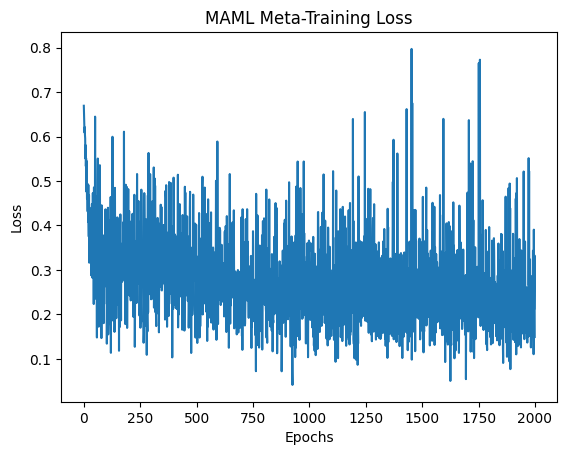

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. The Environment (Moving Circle)

class CircleTaskDistribution:
    def __init__(self):
        self.radius = 2.0
        self.range_min = -5
        self.range_max = 5

    def sample_task(self):
        cx = np.random.uniform(-3, 3)
        cy = np.random.uniform(-3, 3)
        return (cx, cy)

    def sample_data(self, task, k_samples):
        cx, cy = task
        x = np.random.uniform(self.range_min, self.range_max, size=(k_samples, 2))
        dist_sq = (x[:, 0] - cx)**2 + (x[:, 1] - cy)**2
        y = (dist_sq < self.radius**2).astype(np.float32).reshape(-1, 1)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 2. The Model (Functional MLP)

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # We define weights manually so we can update them in the inner loop
        self.w1 = nn.Parameter(torch.randn(2, 64) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(64))
        self.w2 = nn.Parameter(torch.randn(64, 64) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(64))
        self.w3 = nn.Parameter(torch.randn(64, 1) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(1))

    def forward(self, x, params=None):
        if params is None:
            w1, b1, w2, b2, w3, b3 = self.w1, self.b1, self.w2, self.b2, self.w3, self.b3
        else:
            w1, b1, w2, b2, w3, b3 = params

        x = F.relu(F.linear(x, w1.t(), b1))
        x = F.relu(F.linear(x, w2.t(), b2))
        x = torch.sigmoid(F.linear(x, w3.t(), b3))
        return x

    def get_params(self):
        return [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]

# 3. MAML Training Loop (Finn et al. 2017)
def train_maml(dataset, model, epochs=2000, k_shot=10, meta_batch_size=4, alpha=0.1, beta=1e-3):
    optimizer = optim.Adam(model.get_params(), lr=beta)
    loss_fn = nn.BCELoss()

    print(f"Starting MAML Training for {epochs} epochs...")

    loss_history = []

    for epoch in range(epochs):
        meta_loss = 0.0
        optimizer.zero_grad()

        # --- Outer Loop: Iterate over a batch of tasks ---
        for _ in range(meta_batch_size):
            # 1. Sample Task
            task = dataset.sample_task()

            # 2. Sample Data
            # Support Set (D_train): Used for inner update
            x_sup, y_sup = dataset.sample_data(task, k_shot)
            # Query Set (D_val): Used for meta-update
            x_qry, y_qry = dataset.sample_data(task, k_shot)

            # --- Inner Loop (Adaptation) ---
            # Forward pass with theta (current meta-weights)
            y_pred_sup = model(x_sup, params=None)
            loss_sup = loss_fn(y_pred_sup, y_sup)

            # Calculate Gradients: \nabla_theta L(f_theta)
            # create_graph=True is REQUIRED for second-order derivatives (Hessian)
            grads = torch.autograd.grad(loss_sup, model.get_params(), create_graph=True)

            # Update Parameters: theta' = theta - alpha * grads
            # This creates "fast weights" specific to this task
            fast_weights = list(map(lambda p, g: p - alpha * g, model.get_params(), grads))

            # --- Compute Meta-Loss ---
            # Evaluate adapted model (theta') on Quensry Set
            y_pred_qry = model(x_qry, params=fast_weights)
            loss_qry = loss_fn(y_pred_qry, y_qry)

            # Accumulate loss for the batch
            meta_loss += loss_qry

        # --- Meta-Update ---
        # Average loss over the task batch
        meta_loss /= meta_batch_size

        # Compute gradients for theta (the initialization weights)
        # This implicitly computes the gradient of the gradient (second-order)
        meta_loss.backward()

        # Update theta
        optimizer.step()

        loss_history.append(meta_loss.item())
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Meta Loss: {meta_loss.item():.4f}")

    return model, loss_history

# 4. Execution
# Initialize
dataset = CircleTaskDistribution()
maml_model = SimpleMLP()

# Train
trained_maml, history = train_maml(dataset, maml_model, epochs=2000)

# Quick Plot of Training Loss
plt.plot(history)
plt.title("MAML Meta-Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# ***PART 2.2***

In [ ]:
def train_baseline(dataset, model, epochs=2000, batch_size=32):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()

    print("Starting Baseline Training (Joint Training)...")

    for epoch in range(epochs):
        optimizer.zero_grad()

        # 1. Sample data from MANY different tasks mixed together
        # We simulate this by sampling a batch of tasks and aggregating their data
        # without telling the model which task is which.

        all_x = []
        all_y = []

        for _ in range(batch_size):
            t = dataset.sample_task()
            # We sample more points here to approximate the "joint" distribution
            x, y = dataset.sample_data(t, k_samples=10)
            all_x.append(x)
            all_y.append(y)

        # Stack all data into one giant batch
        x_batch = torch.cat(all_x)
        y_batch = torch.cat(all_y)

        # 2. Standard Update
        y_pred = model(x_batch) # Uses internal parameters
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Baseline Loss = {loss.item():.4f}")

    return model

# Initialize and train
baseline_model = SimpleMLP()
trained_baseline = train_baseline(dataset, baseline_model)

Starting Baseline Training (Joint Training)...
Epoch 0: Baseline Loss = 0.6567
Epoch 500: Baseline Loss = 0.2494
Epoch 1000: Baseline Loss = 0.3945
Epoch 1500: Baseline Loss = 0.2938


# ***PART 3.1***

Generating Quantitative Plot...


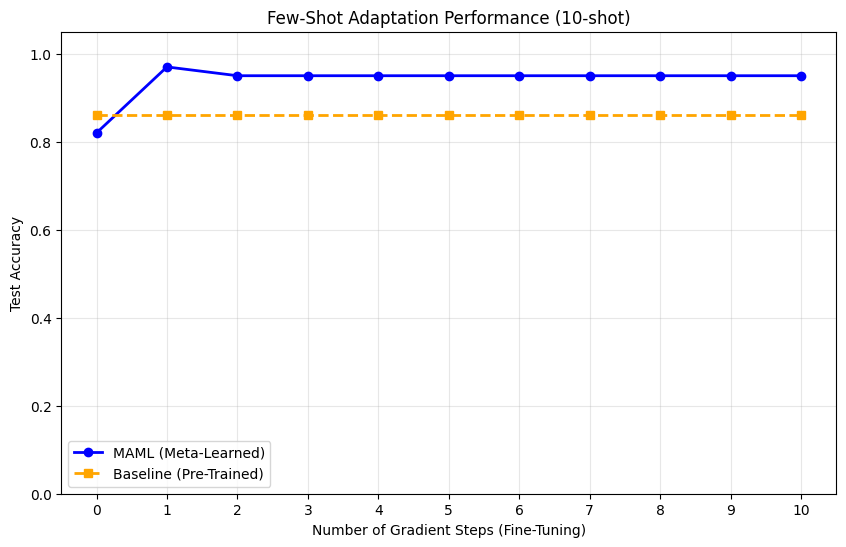

In [ ]:
def evaluate_finetuning(model, dataset, task, steps=10, lr=0.1):
    # 1. Prepare Data
    x_sup, y_sup = dataset.sample_data(task, 10)   # Support Set (K=10)
    x_qry, y_qry = dataset.sample_data(task, 100)  # Query Set (for testing accuracy)

    # 2. Clone Parameters for Adaptation
    # We detach them so we don't affect the original trained model
    params = [p.clone().detach().requires_grad_(True) for p in model.get_params()]

    accuracies = []
    loss_fn = nn.BCELoss()

    # 3. Adaptation Loop
    for step in range(steps + 1):
        # A. Measure Accuracy (Validation)
        with torch.no_grad():
            logits = model(x_qry, params=params)
            preds = (logits > 0.5).float()
            acc = (preds == y_qry).float().mean().item()
            accuracies.append(acc)

        if step == steps: break

        # B. Gradient Step (Training)
        out_sup = model(x_sup, params=params)
        loss = loss_fn(out_sup, y_sup)

        # Calculate gradients using Autograd
        grads = torch.autograd.grad(loss, params)

        # Standard SGD Update
        updated_params = []
        for p, g in zip(params, grads):
            updated_params.append(p - lr * g)
        params = updated_params

    return accuracies

print("Generating Quantitative Plot...")

# Compare on a fresh test task
test_task = dataset.sample_task()

# Run evaluation
maml_accs = evaluate_finetuning(trained_maml, dataset, test_task, steps=10)
base_accs = evaluate_finetuning(trained_baseline, dataset, test_task, steps=10)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(11), maml_accs, 'o-', label='MAML (Meta-Learned)', color='blue', linewidth=2)
plt.plot(range(11), base_accs, 's--', label='Baseline (Pre-Trained)', color='orange', linewidth=2)
plt.xlabel('Number of Gradient Steps (Fine-Tuning)')
plt.ylabel('Test Accuracy')
plt.title('Few-Shot Adaptation Performance (10-shot)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(11))
plt.ylim(0, 1.05)
plt.show()

# ***PART 3.2***

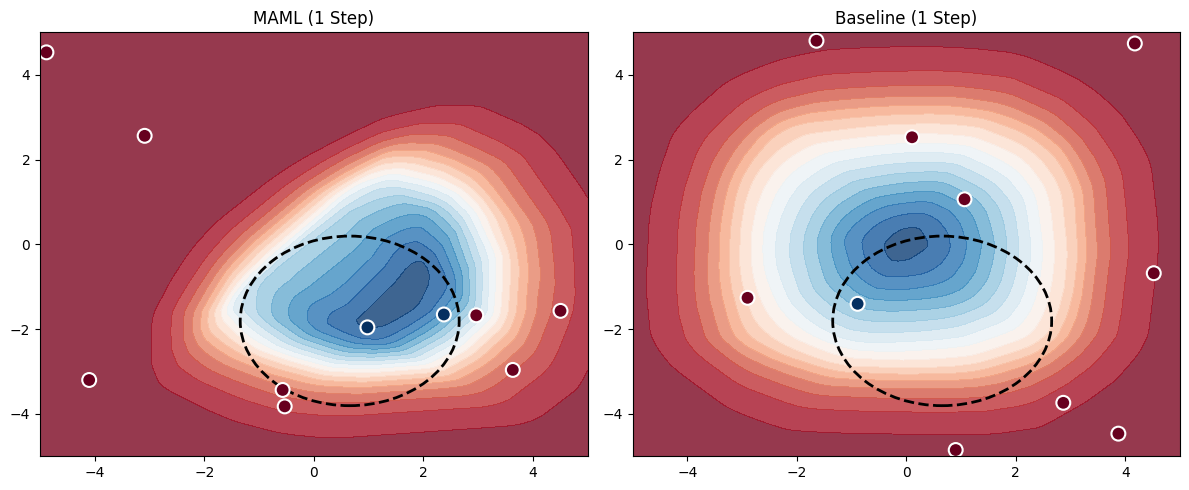

In [ ]:
def plot_decision_boundary(model, dataset, task, ax, title):
    #1. Fine-tune for exactly 1 step
    x_sup, y_sup = dataset.sample_data(task, 10)

    # Initial Params
    params = [p.clone().detach().requires_grad_(True) for p in model.get_params()]

    # Update
    loss_fn = nn.BCELoss()
    out = model(x_sup, params=params)
    loss = loss_fn(out, y_sup)
    grads = torch.autograd.grad(loss, params)
    updated_params = [p - 0.1 * g for p, g in zip(params, grads)] # lr=0.1

    # 2. Generate Heatmap Grid
    # Create a dense grid over [-5, 5]
    xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    #Predict using updated params
    with torch.no_grad():
        probs = model(grid_tensor, params=updated_params).reshape(xx.shape)

    #3. Plot Contour
    contour = ax.contourf(xx, yy, probs.numpy(), levels=20, cmap='RdBu', alpha=0.8)

    # 4. Plot Ground Truth Circle
    cx, cy = task
    circle = plt.Circle((cx, cy), 2.0, color='black', fill=False, linestyle='--', linewidth=2, label='True Boundary')
    ax.add_artist(circle)

    #5. Plot Support Points
    ax.scatter(x_sup[:, 0], x_sup[:, 1], c=y_sup.flatten(), cmap='RdBu', edgecolors='white', s=100, linewidth=1.5)

    ax.set_title(title)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
test_task = dataset.sample_task()

plot_decision_boundary(model, dataset, test_task, axes[0], "MAML (1 Step)")
plot_decision_boundary(trained_baseline, dataset, test_task, axes[1], "Baseline (1 Step)")

plt.tight_layout()
plt.show()